In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from dataset import PSFDataset, ToTensor, Normalize
from net import Net
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

import os
import logging
import argparse
import utils

In [11]:
# Variables

n_zernike = 20
split = 0.1
batch_size = 4
dataset_size = 10000
num_epochs = 500
lr = 0.001

model_dir = 'models/baseline_v2/'
data_dir = 'psfs/'

In [12]:
# Load dataset
dataset = PSFDataset(root_dir=data_dir, size=dataset_size,
                         transform=transforms.Compose([Normalize(), ToTensor()]))
    
# Ensure reproducibility
random_seed= 42
shuffle_dataset = True
    
# Split train-test
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
    
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
    
train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler)
val_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, sampler=val_sampler)

In [14]:
# Load convolutional network
net = Net() 
state_dict = torch.load(os.path.join(model_dir, 'checkpoint.pth'), map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v
        
# Convert to CPU 
net.load_state_dict(new_state_dict)
    
# Loss function
criterion = nn.MSELoss()

In [15]:
# Validation 
net.eval()
val_loss = 0.0
for i_batch, sample_batched in enumerate(val_dataloader):
    zernike = sample_batched['zernike'].type(torch.FloatTensor)
    image = sample_batched['image'].type(torch.FloatTensor)

    outputs = net(image)
    loss = criterion(outputs, zernike)
    val_loss += float(loss)

print('Validation loss: %.3f ' % (val_loss / len(val_dataloader)))

Validation loss: 213.723 


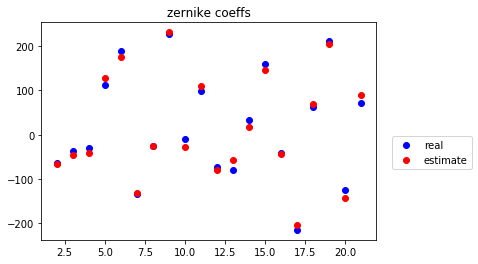

[Zernike 2 ] Estimated: -65.194  | Real: -63.784  | Error: 2.21 %
[Zernike 3 ] Estimated: -45.968  | Real: -36.430  | Error: 26.18 %
[Zernike 4 ] Estimated: -40.816  | Real: -30.032  | Error: 35.91 %
[Zernike 5 ] Estimated: 128.938  | Real: 112.805  | Error: 14.30 %
[Zernike 6 ] Estimated: 176.324  | Real: 188.056  | Error: 6.24 %
[Zernike 7 ] Estimated: -131.326 | Real: -134.138 | Error: 2.10 %
[Zernike 8 ] Estimated: -26.255  | Real: -24.962  | Error: 5.18 %
[Zernike 9 ] Estimated: 231.561  | Real: 226.861  | Error: 2.07 %
[Zernike 10] Estimated: -27.804  | Real: -10.598  | Error: 162.36 %
[Zernike 11] Estimated: 111.077  | Real: 98.921   | Error: 12.29 %
[Zernike 12] Estimated: -79.830  | Real: -71.921  | Error: 11.00 %
[Zernike 13] Estimated: -57.771  | Real: -80.475  | Error: 28.21 %
[Zernike 14] Estimated: 17.814   | Real: 33.027   | Error: 46.06 %
[Zernike 15] Estimated: 145.516  | Real: 160.774  | Error: 9.49 %
[Zernike 16] Estimated: -42.465  | Real: -42.231  | Error: 0.55 %
[

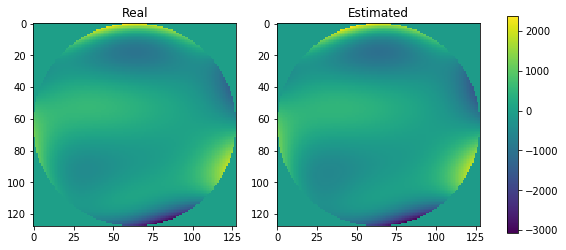

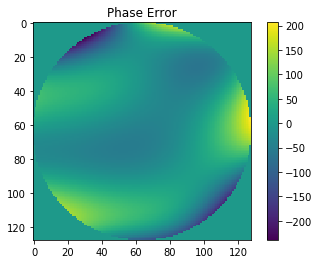

In [22]:
 # Visualization: zernike coefficients and estimate 
import numpy as np
import matplotlib.pyplot as plt
import aotools
    
sample = dataset[val_indices[0]]
zernike = sample['zernike'].unsqueeze(0).type(torch.FloatTensor)
image = sample['image'].unsqueeze(0).type(torch.FloatTensor)
outputs = net(image)
loss = criterion(outputs, zernike)
outputs = outputs.detach().numpy()
zernike = zernike.detach().numpy()
x = np.arange(20) + 2
plt.plot(x, np.transpose(zernike), 'ro', color='blue', label='real')
plt.plot(x, np.transpose(outputs), 'ro', label='estimate')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title('zernike coeffs')
plt.show()
    
id = 0
total_error = 0.0
for i in np.nditer(zernike):
    estimate = "%.3f" % outputs[0,id]
    real = "%.3f" % i
    error = i - outputs[0,id]
    relative_error = 100*np.abs(error/i)
    total_error += relative_error
    print("[Zernike %-*s] Estimated: %-*s | Real: %-*s | Error: %0.2f %%" % (2, str(id+2), 8, estimate, 8, real, relative_error))
    id += 1
print("Average error per coeff: %0.2f %%" % (total_error/20.))    
print('RMS Loss: %0.3f'% (loss))
        
# Generate the Zernike modal basis
nbOfZernike = 20
Zs = aotools.zernikeArray(nbOfZernike + 1, 128, norm='rms')  
real_phase = np.squeeze(np.sum(zernike[0, :, None, None] * Zs[1:, :, :], axis=0))
estimated_phase = np.squeeze(np.sum(outputs[0, :, None, None] * Zs[1:, :, :], axis=0))
f, axarr = plt.subplots(1,2, figsize=(10, 10))
im = axarr[0].imshow(real_phase)
axarr[0].set_title("Real")
axarr[1].imshow(estimated_phase)
axarr[1].set_title("Estimated")
f.colorbar(im, ax=axarr.ravel().tolist(), shrink=0.4)
plt.show()
phase_error = real_phase - estimated_phase
plt.imshow(phase_error)
plt.colorbar()
plt.title('Phase Error')
plt.show()

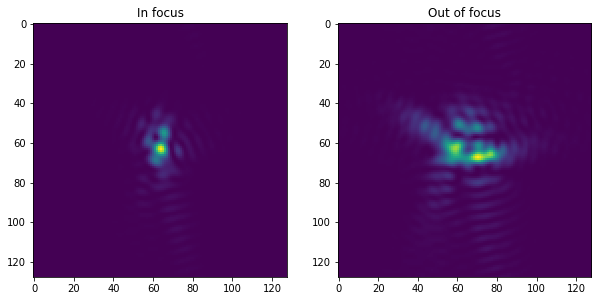

confParse.py -> calcParams: Overriding sci FOV with pxlscale


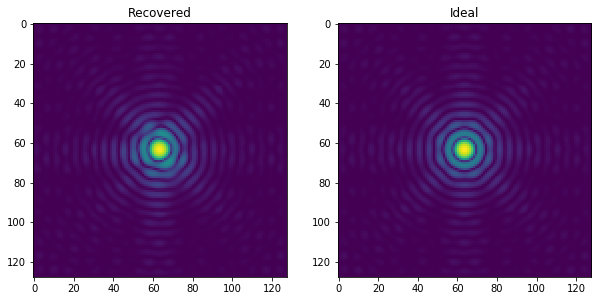

In [23]:
from soapy import SCI, confParse
from astropy.visualization import simple_norm
    
image = sample['image'].detach().numpy()

# Input images
f, axarr = plt.subplots(1,2, figsize=(10, 10))
im = axarr[0].imshow(image[0,:,:])
axarr[0].set_title("In focus")
axarr[1].imshow(image[1,:,:])
axarr[1].set_title("Out of focus")
plt.show()
    
# Reconstruct unaberrated PSFs
pixelScale = 0.01
diameter = 10
SOAPY_CONF = "config/psf.yaml"
config = confParse.loadSoapyConfig(SOAPY_CONF)
config.scis[0].pxlScale = pixelScale
config.calcParams()
config.tel.telDiam = diameter
config.calcParams()
mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)
psfObj = SCI.PSF(config, nSci=0, mask=mask)
aberrations = np.zeros((128,128))
unaberrated = np.copy(psfObj.frame(aberrations.astype(float)))
recovered_psf = np.copy(psfObj.frame(np.squeeze(phase_error.astype(float))))
    
# Recovered images
f, axarr = plt.subplots(1,2, figsize=(10, 10))
recovered_psf = np.abs(recovered_psf)
im = axarr[0].imshow(recovered_psf, norm=simple_norm(recovered_psf, 'log'))
axarr[0].set_title("Recovered")
axarr[1].imshow(unaberrated, norm=simple_norm(unaberrated, 'log'))
axarr[1].set_title("Ideal")
plt.show()